In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

Library yang digunakan untuk melakukan data cleaning dan EDA

In [2]:
data_stud = pd.read_csv('studentInfo.csv')
data_regis = pd.read_csv('studentRegistration.csv')
data_studvle = pd.read_csv('StudentVle.csv')
data_vle = pd.read_csv('vle.csv')

kode ini membaca empat file CSV yang berbeda ('studentInfo.csv', 'studentRegistration.csv', 'StudentVle.csv', 'vle.csv') dan menyimpannya masing-masing dalam empat DataFrame yang berbeda (data_stud, data_regis, data_studvle, dan data_vle)

In [3]:
def inner_merge(left_df,right_df,right_cols,on_cols):
    right_df = right_df[right_cols]
    left_df = left_df.merge(right_df, on = on_cols)
    return left_df.drop_duplicates()

fungsi ini memberikan hasil penggabungan inner dari dua DataFrame dengan mengambil kolom tertentu dari bagian kanan dan menggunakan kolom-kolom tertentu sebagai kunci penggabungan.

In [4]:
score_deadline = 120
click_deadline = 120
withdraw_deadline = 120

mendefinisikan variabel hari

In [5]:
def create_score_df(score_deadline):
#menggabungkan 2 data
    df1 = pd.read_csv('assessments.csv')
    df2 = pd.read_csv('studentAssessment.csv')
    
#memanggil inner_merge
    score_df = inner_merge(df1,
                           df2,
                           df2.columns,
                           ['id_assessment'],)
    
#filter data yang kurang dari core_deadline
    score_df = score_df[score_df['date'] < score_deadline]

#filter data yang memiliki assessment_type selain 'Exam'
    score_df = score_df[score_df['assessment_type'] != 'Exam']

#Handling null value score dengan cara langsung dihapus
    score_df = score_df.dropna(subset = ['score']) 

    score_df.isnull().sum()

#menghapus attribute yang tidak digunakan    
    score_df = score_df.drop(['date','date_submitted', 'is_banked','id_assessment'],axis = 1)

# Mengalikan 'weight' dengan 'score' dan membagi hasilnya dengan 100
    score_df['weighted_score'] = score_df['weight'] * score_df['score'] / 100

    score_df = score_df.groupby(['code_module', 'code_presentation', 'id_student'])[['weighted_score', 'weight']].sum().reset_index()
    score_df['mean_score'] = score_df['weighted_score'] / (score_df['weight'] / 100)
    
# Menangani nilai yang hilang pada mean_score dengan mengganti dengan nilai rata-rata umum
    mean_score_global = score_df['mean_score'].mean()
    score_df['mean_score'].fillna(mean_score_global, inplace=True)
    score_df = score_df.drop(['weighted_score', 'weight'], axis=1)
    
# Mengganti nama kolom menjadi 'mean_score_day{score_deadline}'
    score_df = score_df.rename(columns={'mean_score': f'mean_score_day{score_deadline}'})
    
    return score_df

fungsi untuk menghitung score berdasarkan deadline

In [6]:
def create_click_df(click_deadline):

    clicks = data_studvle

    clicks = inner_merge(clicks,
                         data_vle,
                         ['id_site','code_module','code_presentation','activity_type'],
                         ['id_site','code_module','code_presentation'],
                        )

    clicks = clicks.drop('id_site', axis = 1)

    def clicks_xx(clicks,xx):
        temp = clicks[clicks['date'] <= xx]
        temp = temp.drop('date', axis = 1)
        temp = temp.groupby(['code_module','code_presentation','id_student','activity_type']).mean() #Mengganti nama kolom 'sum_click' menjadi 'sum_click{xx} mean' di DataFrame temp.
        temp = temp.rename(columns = {'sum_click': f'sum_click{xx} mean'})
        temp = temp.reset_index() # Mengatur ulang indeks DataFrame temp. Ini membantu mengisi kolom-kolom yang hilang setelah pengelompokan untuk persiapan penggabungan selanjutnya. 
        return temp

    #Membuat pivot table dari hasil fungsi clicks_xx dengan indeks berdasarkan beberapa kolom tertentu dan nilai-nilai dalam kolom 'activity_type'. Mengisi nilai kosong dengan 0.
    click_data = pd.pivot_table(data = clicks_xx(clicks,click_deadline), 
                                index = ['code_module','code_presentation','id_student'],
                                columns = 'activity_type', 
                                values = [f'sum_click{click_deadline} mean'],
                                fill_value = 0,
                               ).reset_index()

    # menggabungkan multi index
    click_data = pd.concat([click_data['code_module'],
                            click_data['code_presentation'],
                            click_data['id_student'], 
                            click_data[f'sum_click{click_deadline} mean']], axis=1)
    return click_data

Fungsi ini menciptakan DataFrame yang berisi informasi klik untuk setiap aktivitas berdasarkan modul, presentasi, dan id mahasiswa, dengan kolom 'sum_click{click_deadline} mean' yang menunjukkan jumlah rata-rata klik hingga batas waktu tertentu.

In [7]:
# merge score_df and click_df
def create_final_df(withdraw_deadline, score_df, click_df):

    final_df = inner_merge(click_df,
                           data_stud,
                           data_stud.columns,
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df.replace('Distinction','Pass') # Menggantikan nilai 'Distinction' dengan 'Pass' di dalam DataFrame final_df.

    final_df = inner_merge(final_df, 
                           data_regis,
                           ['code_module', 'code_presentation', 'id_student', 'date_unregistration'],
                           ['code_module', 'code_presentation', 'id_student'],
                          ) #Melakukan merge antara final_df dan data_regis berdasarkan beberapa kolom tertentu. Hasilnya disimpan dalam DataFrame final_df

    #Memfilter baris di DataFrame final_df dimana 'final_result' bukan 'Withdrawn' atau tanggal unregistration lebih besar dari withdraw_deadline.
    final_df = final_df[(final_df['final_result'] != 'Withdrawn') | 
                       (final_df['date_unregistration'] > withdraw_deadline)]

    final_df = final_df.reset_index()

    final_df = final_df.drop(['date_unregistration','index'],axis = 1)

    final_df = inner_merge(final_df,
                           score_df,
                           score_df.columns,
                           ['code_module', 'code_presentation', 'id_student'])
    
    final_df = final_df.replace('Withdrawn','Fail') # Menggantikan nilai 'Withdrawn' dengan 'Fail' di dalam DataFrame final_df.

    return final_df

Fungsi create_final_df ini menggabungkan DataFrame score_df dan click_df dengan beberapa DataFrame lainnya seperti data_stud, data_regis, dan data_studvle

In [8]:
score_df = create_score_df(score_deadline)
click_df = create_click_df(click_deadline)
final_df = create_final_df(withdraw_deadline, score_df, click_df)
final_df.head() #menampilkan 5 data teratasnya

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_score_day120
0,AAA,2013J,11391,0.0,0.0,0.0,3.641026,0.0,3.500000,0.0,...,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,81.6
1,AAA,2013J,28400,0.0,0.0,0.0,2.891089,0.0,4.586957,0.0,...,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,69.2
2,AAA,2013J,31604,0.0,0.0,0.0,3.037037,1.0,4.058824,0.0,...,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,72.4
3,AAA,2013J,32885,0.0,0.0,0.0,3.083333,2.0,3.605263,0.0,...,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,51.0
4,AAA,2013J,38053,7.0,0.0,0.0,3.364238,0.0,4.267606,0.0,...,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,73.0


In [9]:
final_df.tail() #menampilkan 5 data terbawahnya

,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_score_day120
23093,GGG,2014J,2606765,0.0,0.0,0.0,0.000000,1.0,1.000000,0.0,...,F,London Region,Lower Than A Level,80-90%,0-35,0,30,N,Pass,72.529184
23094,GGG,2014J,2620947,0.0,0.0,0.0,3.500000,0.0,3.125000,0.0,...,F,Scotland,A Level or Equivalent,80-90%,0-35,0,30,Y,Pass,72.529184
23095,GGG,2014J,2645731,0.0,0.0,0.0,1.000000,1.0,8.571429,0.0,...,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Pass,72.529184
23096,GGG,2014J,2648187,0.0,0.0,0.0,0.000000,1.0,2.888889,0.0,...,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,72.529184
23097,GGG,2014J,2684003,0.0,0.0,0.0,2.214286,0.0,3.680000,0.0,...,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Pass,72.529184


In [10]:
#untuk memberikan informasi ringkas tentang sebuah DataFrame, termasuk informasi tentang tipe data, jumlah baris dan kolom, jumlah nilai yang tidak kosong, dan sebagainya.
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23098 entries, 0 to 23097
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           23098 non-null  object 
 1   code_presentation     23098 non-null  object 
 2   id_student            23098 non-null  int64  
 3   dataplus              23098 non-null  float64
 4   dualpane              23098 non-null  float64
 5   externalquiz          23098 non-null  float64
 6   forumng               23098 non-null  float64
 7   glossary              23098 non-null  float64
 8   homepage              23098 non-null  float64
 9   htmlactivity          23098 non-null  float64
 10  oucollaborate         23098 non-null  float64
 11  oucontent             23098 non-null  float64
 12  ouelluminate          23098 non-null  float64
 13  ouwiki                23098 non-null  float64
 14  page                  23098 non-null  float64
 15  questionnaire      

In [11]:
#Handling null value 'imd_band' dengan cara mengisinya sesuai dengan region yang sama
final_df['imd_band'] = final_df.apply(lambda x: final_df[final_df['region']==x['region']]['imd_band'].mode()[0] \
    if pd.isna(x['imd_band']) else x['imd_band'], axis=1)

In [12]:
# menghitung jumlah null value pada 'final_df'
final_df.isnull().sum()

code_module             0
code_presentation       0
id_student              0
dataplus                0
dualpane                0
externalquiz            0
forumng                 0
glossary                0
homepage                0
htmlactivity            0
oucollaborate           0
oucontent               0
ouelluminate            0
ouwiki                  0
page                    0
questionnaire           0
quiz                    0
repeatactivity          0
resource                0
sharedsubpage           0
subpage                 0
url                     0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
mean_score_day120       0
dtype: int64

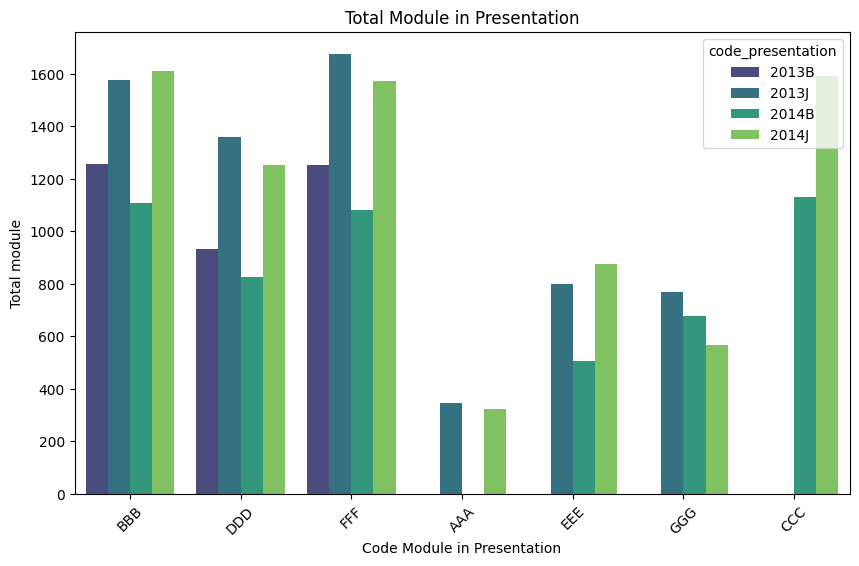

In [13]:
#Visualization : memvisualisasikan berdasarkan tahun, bulan, kode modul dan jumlah modul. 
#Jadi dengan adanya ini kita dapat mengetahui contohnya pada tahun 2013 dan mulai presentasi pada bulan Februari, untuk code modul BBB berjumlah lebih dari 1500 
modul_per_tahun = final_df.groupby(['code_presentation', 'code_module'])['code_module'].count().reset_index(name='total_module')

# Membuat grafik bar dengan seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='code_module', y='total_module', hue='code_presentation', data=modul_per_tahun, palette='viridis')
plt.title('Total Module in Presentation')
plt.xlabel('Code Module in Presentation')
plt.ylabel('Total module')
plt.xticks(rotation=45)
plt.show()

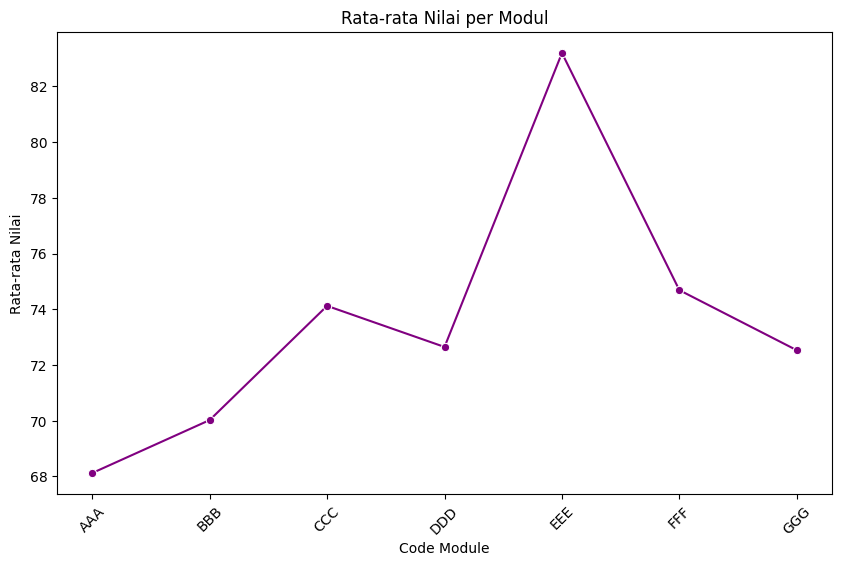

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

#Visualization : memvisualisasikan berdasarkan modul dan nilai rata-ratanya.
#Jadi dengan adanya ini kita dapat mengetahui modul mana yang memiliki rata-rata paling buruk untuk evaluasi ke depannya

# Mengelompokkan data dan menghitung nilai rata-rata untuk setiap modul
rata_rata_per_modul = final_df.groupby('code_module')['mean_score_day120'].mean().reset_index(name='rata_rata')

# Membuat line chart dengan seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='code_module', y='rata_rata', data=rata_rata_per_modul, marker='o', color='purple')
plt.title('Rata-rata Nilai per Modul')
plt.xlabel('Code Module')
plt.ylabel('Rata-rata Nilai')
plt.xticks(rotation=45)
plt.show()


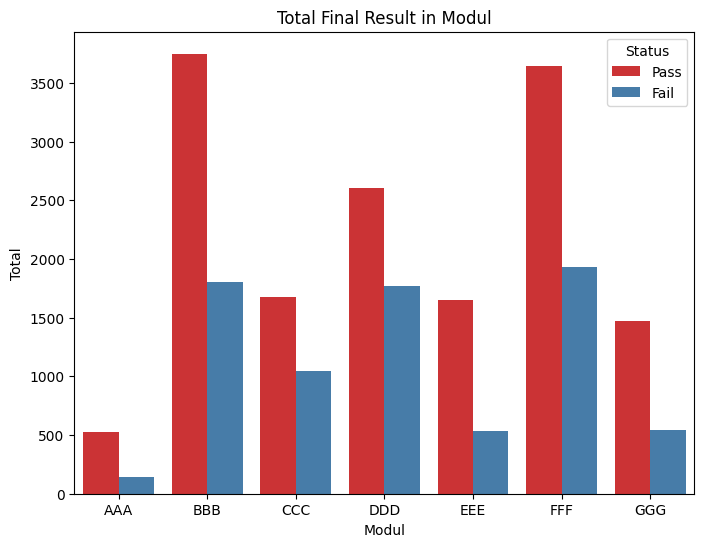

In [15]:
#Visualization : memvisualisasikan jumlah siswa yang pass dan fail pada masing-masing modul
# Membuat countplot menggunakan Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=final_df, x='code_module', hue='final_result', palette='Set1')
plt.title('Total Final Result in Modul')
plt.xlabel('Modul')
plt.ylabel('Total')
plt.legend(title='Status')
plt.show()

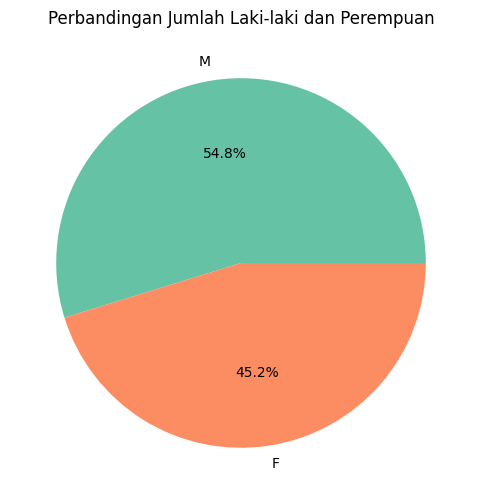

In [16]:
#Visualization : memvisualisasikan perbandingan siswa laki-laki dan perempuan
gender_counts = final_df['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Perbandingan Jumlah Laki-laki dan Perempuan')
plt.show()

In [17]:
def preprocess_and_train(final_df):

#membagi data targer
    X = final_df.drop('final_result',axis = 1)
    column_names = X.columns
    y = final_df['final_result']

#Encoding data categorical
    le = LabelEncoder()
    encode_dict = {}
    Xcat_features = ['code_module', 'code_presentation',
                    'gender', 'region',
                    'highest_education',  
                    'age_band','disability','imd_band'
                   ]

    for cat_feature in Xcat_features: 
        X[cat_feature] = le.fit_transform(X[cat_feature])
        encode_dict[cat_feature] = le.classes_

    y = le.fit_transform(y)
    encode_dict['final_result'] = le.classes_

    X = X.to_numpy()

#Splitting dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Apply SMOTE for class imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    selector = SelectKBest(score_func=mutual_info_classif, k= 20)  # Memilih 20 fitur terbaik
    X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
    X_test_selected = selector.transform(X_test)

    return X_train_resampled, X_test, y_train_resampled, y_test, column_names, encode_dict
    

In [18]:
X_train, X_test, y_train, y_test, column_names, encode_dict = preprocess_and_train(final_df)

In [19]:
from xgboost import XGBClassifier
cat_reg = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='error',  # 'error' for binary classification
    verbosity=0
)


def train(X_train, y_train, X_test, y_test, reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # Menghitung akurasi
    accuracy = accuracy_score(y_test, y_pred)

    print(f'Akurasi: {accuracy}')
    # Classification Report
    report = classification_report(y_test, y_pred)
    print(f'Classification Report:\n{report}')

# Panggil fungsi train dengan data yang sudah dipisah
train(X_train, y_train, X_test, y_test, cat_reg)


Akurasi: 0.7562770562770563
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59       774
           1       0.78      0.87      0.83      1536

    accuracy                           0.76      2310
   macro avg       0.73      0.70      0.71      2310
weighted avg       0.75      0.76      0.75      2310



In [20]:
days_list = [120, 150, 180, 210, 230, 260]

for days in days_list:
    score_deadline = days
    click_deadline = days

    score_df = create_score_df(score_deadline)
    click_df = create_click_df(click_deadline)
    final_df = create_final_df(withdraw_deadline, score_df, click_df)

    X_train, X_test, y_train, y_test, column_names, encode_dict = preprocess_and_train(final_df)


    print(f'Number of days in data: {days}')


    train(X_train, y_train, X_test, y_test, cat_reg)

    print('\n')


Number of days in data: 120
Akurasi: 0.7471861471861472
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.50      0.57       774
           1       0.78      0.87      0.82      1536

    accuracy                           0.75      2310
   macro avg       0.72      0.69      0.70      2310
weighted avg       0.74      0.75      0.74      2310



Number of days in data: 150
Akurasi: 0.7837721191195511
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       740
           1       0.82      0.88      0.85      1577

    accuracy                           0.78      2317
   macro avg       0.75      0.73      0.74      2317
weighted avg       0.78      0.78      0.78      2317



Number of days in data: 180
Akurasi: 0.7919723780750971
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       